## 12- Temporal features dataset modeling experiment 3 - Autogluon TabularPredictor (AutoML)
* Using the open-source Autogluon AutoML library by AWS.
* Using temporal features dataset.
* Autogluon will train an ensemble of models and find the best performing one.
    * Model will be __fit__ on the __train__ set.
    * The __validation__ set will be used to pick the best-performing model.
    * Final evaluation will be done on the __test__ set.

#### Stages
1. __Reading data__.
2. __Autogluon model training__.
3. __Model evaluation__.
4. __Saving predictor__.
5. __Feature importances on validation set__.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold  # for splitting into train/val/test based on customer id while keeping fraud ratio the same for the three sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    average_precision_score, 
    confusion_matrix, 
    classification_report
)
import autogluon
from autogluon.tabular import TabularPredictor
import warnings
warnings.filterwarnings("ignore")
import os

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 420

### 1- Reading data

In [3]:
train_df = pd.read_csv("data/train_temporal_features.csv")
val_df = pd.read_csv("data/validation_temporal_features.csv")
test_df = pd.read_csv("data/test_temporal_features.csv")

In [4]:
train_df.shape

(476608, 55)

In [5]:
train_df.head()

,step,amount,amount_divided_by_cust_day_mean_last_30_days,amount_divided_by_cust_day_mean_last_7_days,amount_divided_by_cust_prior_mean,cust_active_day_count_prior_to_day,cust_amount_mean_prior_to_row,cust_amount_std_prior_to_row,cust_amount_sum_prior_to_day,cust_amount_sum_prior_to_row,cust_day_amount_mean_last_30_days,cust_day_amount_mean_last_7_days,cust_day_amount_std_last_30_days,cust_day_amount_std_last_7_days,cust_day_total_amount,cust_day_total_transactions,cust_days_since_previous_active_day,cust_days_since_previous_transaction,cust_mean_day_gap_last_30_days,cust_mean_day_gap_last_7_days,cust_prev_day_total_amount,cust_total_amount_last_30_days,cust_total_amount_last_7_days,cust_total_transactions_last_30_days,cust_total_transactions_last_7_days,cust_txn_count_prior_to_day,cust_txn_count_prior_to_row,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.303248,-0.336575,-0.389404,0.184301,-1.618242,-0.756986,-0.468526,0.785494,0.782420,0.076636,0.055546,-0.323900,-0.100796,-0.275646,-0.262811,0.184301,0.184301,0.217557,-0.164692,-0.320688,0.076004,0.053510,0.414661,0.025138,1.775647,-1.619035,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,0.018468,0.379018,0.259294,1.780770,-1.618242,-0.756986,-0.468526,0.794361,0.791268,-0.127464,-0.253273,-0.347693,-0.194408,-0.042439,-0.262811,1.780769,1.780770,0.057332,-0.164692,-0.320688,-0.128219,-0.255846,0.414661,0.025138,1.754951,-1.619035,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.098661,-0.030542,0.294679,1.199533,-1.618242,-0.756986,-0.468526,0.844915,0.841711,0.163293,-0.390076,-0.193254,-0.233214,-0.127344,-0.262811,1.199533,1.199533,-0.022781,-0.164692,-0.320688,0.162712,-0.392887,0.573166,0.025138,1.858431,-1.619035,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.186943,-0.216873,-0.170615,0.761448,-1.618242,-0.756986,-0.468526,0.678118,0.675279,0.432978,-0.197171,0.081554,-0.200984,-0.191338,-0.262811,0.761447,0.761448,-0.102893,-0.164692,-0.320688,0.432559,-0.199646,0.493913,0.025138,0.616673,-1.619035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,-0.017797,0.360280,0.343973,1.600809,-1.618242,-0.756986,-0.468526,-0.008632,-0.009972,-0.181785,-0.329459,-0.357290,-0.251294,-0.068727,-0.262811,1.600809,1.600809,0.217557,-0.164692,-0.320688,-0.182572,-0.332164,0.414661,0.025138,0.202753,-1.619035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [6]:
val_df.shape

(60291, 55)

In [7]:
val_df.head()

,step,amount,amount_divided_by_cust_day_mean_last_30_days,amount_divided_by_cust_day_mean_last_7_days,amount_divided_by_cust_prior_mean,cust_active_day_count_prior_to_day,cust_amount_mean_prior_to_row,cust_amount_std_prior_to_row,cust_amount_sum_prior_to_day,cust_amount_sum_prior_to_row,cust_day_amount_mean_last_30_days,cust_day_amount_mean_last_7_days,cust_day_amount_std_last_30_days,cust_day_amount_std_last_7_days,cust_day_total_amount,cust_day_total_transactions,cust_days_since_previous_active_day,cust_days_since_previous_transaction,cust_mean_day_gap_last_30_days,cust_mean_day_gap_last_7_days,cust_prev_day_total_amount,cust_total_amount_last_30_days,cust_total_amount_last_7_days,cust_total_transactions_last_30_days,cust_total_transactions_last_7_days,cust_txn_count_prior_to_day,cust_txn_count_prior_to_row,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.020728,0.007807,-0.260220,1.586267,-1.618242,-0.756986,-0.468526,0.899909,0.896585,0.355706,0.735242,-0.054908,0.463860,-0.070851,-0.262811,1.586266,1.586267,-0.022781,-0.164692,-0.320688,0.355241,0.734387,0.652418,1.254787,2.127478,-1.619035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.168078,-0.027586,-0.147065,0.855063,-1.618242,-0.756986,-0.468526,0.720360,0.717428,-0.121048,-0.185091,-0.367730,-0.181304,-0.177663,-0.262811,0.855063,0.855063,0.217557,0.101453,-0.320688,-0.121799,-0.187545,0.414661,0.025138,1.837735,-1.619035,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.071645,-0.046881,-0.155973,1.333595,-1.618242,-0.756986,-0.468526,-0.016335,-0.017659,0.321698,0.084561,-0.151986,-0.119046,-0.107761,-0.262811,1.333595,1.333595,0.297669,-0.031619,-0.320688,0.321212,0.082576,0.573166,0.025138,-0.314646,-1.619035,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.234106,-0.246544,-0.306498,0.527408,-1.618242,-0.756986,-0.468526,0.944459,0.941038,0.221221,0.002250,-0.192809,-0.042901,-0.225526,-0.262811,0.527407,0.527408,-0.022781,-0.164692,-0.320688,0.220675,0.000122,0.810923,0.639962,2.086087,-1.619035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.622063,0.855604,0.948956,4.776022,-1.618242,-0.756986,-0.468526,2.731927,2.724605,0.330604,-0.124840,-0.113870,-0.131493,0.395099,-0.262811,4.776021,4.776022,-0.022781,-0.164692,-0.320688,0.330123,-0.127190,0.731670,0.025138,2.023999,-1.619035,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test_df.shape

(57744, 55)

In [9]:
test_df.head()

,step,amount,amount_divided_by_cust_day_mean_last_30_days,amount_divided_by_cust_day_mean_last_7_days,amount_divided_by_cust_prior_mean,cust_active_day_count_prior_to_day,cust_amount_mean_prior_to_row,cust_amount_std_prior_to_row,cust_amount_sum_prior_to_day,cust_amount_sum_prior_to_row,cust_day_amount_mean_last_30_days,cust_day_amount_mean_last_7_days,cust_day_amount_std_last_30_days,cust_day_amount_std_last_7_days,cust_day_total_amount,cust_day_total_transactions,cust_days_since_previous_active_day,cust_days_since_previous_transaction,cust_mean_day_gap_last_30_days,cust_mean_day_gap_last_7_days,cust_prev_day_total_amount,cust_total_amount_last_30_days,cust_total_amount_last_7_days,cust_total_transactions_last_30_days,cust_total_transactions_last_7_days,cust_txn_count_prior_to_day,cust_txn_count_prior_to_row,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.048201,0.166206,0.012031,1.449933,-1.618242,-0.756986,-0.468526,0.830000,0.826829,-0.043617,-0.149414,-0.320924,-0.246848,-0.090766,-0.262811,1.449932,1.449933,0.057332,0.101453,-0.320688,-0.044321,-0.151806,0.493913,0.025138,1.941215,-1.619035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.068440,-0.130731,-0.184810,1.349501,-1.618242,-0.756986,-0.468526,1.458078,1.453536,0.688449,0.177854,0.347076,0.285659,-0.105437,-0.262811,1.349500,1.349501,0.618120,0.899887,-0.320688,0.688183,0.176031,0.810923,1.869611,1.361728,-1.619035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.184287,-0.227839,-0.348359,0.774627,-1.618242,-0.756986,-0.468526,1.156532,1.152648,0.532806,0.746882,0.089442,0.757968,-0.189413,-0.262811,0.774626,0.774627,-0.022781,-0.031619,-0.320688,0.532447,0.746048,0.573166,0.639962,2.023999,-1.619035,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,0.027718,0.149313,0.007153,1.826669,-1.618242,-0.756986,-0.468526,0.937086,0.933681,0.186366,-0.017516,-0.304691,-0.199692,-0.035734,-0.262811,1.826668,1.826669,0.057332,-0.164692,-0.320688,0.185800,-0.019679,0.414661,0.025138,1.858431,-1.619035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.457954,1.413097,0.920115,3.961655,-1.618242,-0.756986,-0.468526,0.814304,0.811167,-0.159839,-0.202905,-0.345686,-0.157644,0.276139,-0.262811,3.961654,3.961655,0.297669,-0.164692,-0.320688,-0.160613,-0.205391,0.414661,0.025138,1.817039,-1.619035,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### 2- Autogluon model training

In [10]:
save_path = 'models/temporal-features-autogluon-tabular-predictor' 

In [11]:
%%time

predictor = TabularPredictor(
    label="fraud",
    problem_type="binary",
    eval_metric="f1",
    path=save_path,
    sample_weight="balance_weight"
).fit(
    train_data=train_df,
    tuning_data=val_df,
    presets="medium_quality",
    verbosity=False,
    use_bag_holdout=True,
    num_cpus=os.cpu_count(),
    # Reproducbile results
    ag_args_fit={"random_seed": RANDOM_SEED}, # seed that every model will use
    ag_args_ensemble={
        "model_random_seed": RANDOM_SEED, # seed for per-fold child models
        "random_state": RANDOM_SEED  # seed for CV split in bagging
    }  
)

CPU times: user 4h 19min 6s, sys: 1min 36s, total: 4h 20min 43s
Wall time: 23min 41s


### 3- Model evaluation

In [12]:
def evaluate_model(model, X, y, name="model"):
    # # predictions
    # if hasattr(model, "predict_proba"):
    #     scores = model.predict_proba(X)[:, 1]
    # elif hasattr(model, "decision_function"):
    #     scores = model.decision_function(X)
    # else:
        # scores = model.predict(X)
    scores = model.predict(X)
        
    preds = (scores >= 0.5).astype(int)

    # metrics
    metrics = {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "roc_auc": roc_auc_score(y, scores) if len(np.unique(y)) > 1 else np.nan,
        "avg_precision": average_precision_score(y, scores),
        "classification_report": classification_report(y, preds, digits=3)
    }
    print(f"\n{name} — metrics\n")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc", "avg_precision"]:
        v = metrics[k]
        print(f"{k:>14}: {v:.4f}" if v==v else f"{k:>14}: nan")
    print("\nClassification report:\n", metrics["classification_report"])
    
    # confusion matrix
    cm = confusion_matrix(y, preds, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        fmt="d",
        cbar=True,
        annot=True,
        xticklabels=("Non_Fraudulent", "Fraudulent"),
        yticklabels=("Non_Fraudulent", "Fraudulent"),
        ax=ax,
        cmap="cividis"
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
    return metrics

#### 3.1- Evaluation on validation set

In [13]:
%%time

predictor.evaluate(val_df)

CPU times: user 29.7 s, sys: 176 ms, total: 29.9 s
Wall time: 3.16 s


{'f1': 0.8240437158469945,
 'accuracy': 0.9973296180192732,
 'balanced_accuracy': np.float64(0.8737235937578403),
 'mcc': 0.8270606425058674,
 'roc_auc': np.float64(0.9978443978770137),
 'precision': 0.9172749391727494,
 'recall': 0.748015873015873}

In [14]:
leaderboard_val = predictor.leaderboard(val_df).sort_values("score_val", ascending=False)

In [15]:
leaderboard_val.shape

(12, 13)

In [16]:
leaderboard_val.head(50)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.824044,0.824044,f1,3.012558,2.881767,929.933338,0.008497,0.005625,1.148313,2,True,12
1,NeuralNetTorch,0.814081,0.814081,f1,0.260784,0.268766,534.194085,0.260784,0.268766,534.194085,1,True,10
2,LightGBM,0.792339,0.792339,f1,1.302150,1.235434,82.244954,1.302150,1.235434,82.244954,1,True,2
3,XGBoost,0.783705,0.783705,f1,0.758321,0.855800,52.304603,0.758321,0.855800,52.304603,1,True,9
4,LightGBMXT,0.783567,0.783567,f1,2.916403,2.571048,189.285872,2.916403,2.571048,189.285872,1,True,1
5,LightGBMLarge,0.783439,0.783439,f1,2.660096,2.398958,218.965523,2.660096,2.398958,218.965523,1,True,11
6,NeuralNetFastAI,0.777778,0.777778,f1,0.287257,0.255045,155.342677,0.287257,0.255045,155.342677,1,True,8
7,RandomForestEntr,0.745921,0.745921,f1,0.153054,0.091082,42.884650,0.153054,0.091082,42.884650,1,True,4
8,ExtraTreesEntr,0.745006,0.745006,f1,0.222713,0.133887,24.198132,0.222713,0.133887,24.198132,1,True,7
9,ExtraTreesGini,0.743130,0.743130,f1,0.184453,0.144885,24.557079,0.184453,0.144885,24.557079,1,True,6



Temporal Features Experiment - Autogluon Validation Set — metrics

      accuracy: 0.9973
     precision: 0.9173
        recall: 0.7480
            f1: 0.8240
       roc_auc: 0.8737
 avg_precision: 0.6882

Classification report:
               precision    recall  f1-score   support

           0      0.998     0.999     0.999     59787
           1      0.917     0.748     0.824       504

    accuracy                          0.997     60291
   macro avg      0.958     0.874     0.911     60291
weighted avg      0.997     0.997     0.997     60291



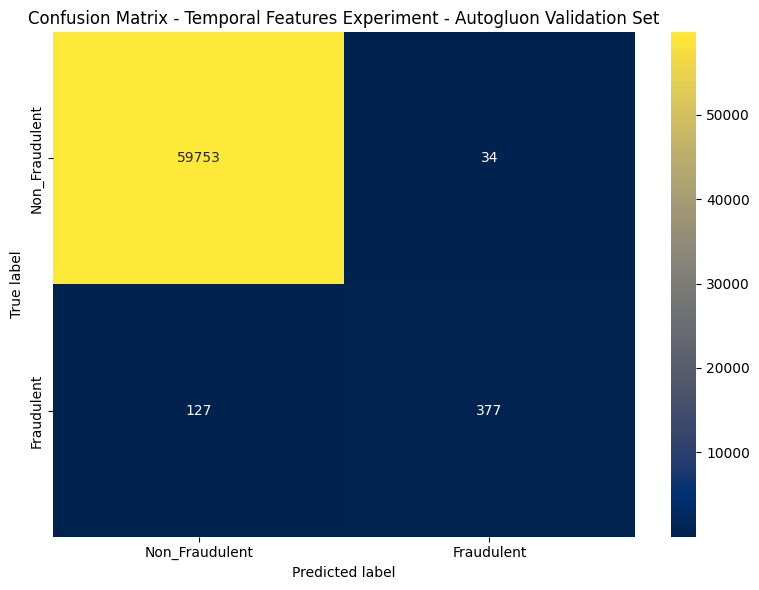

CPU times: user 29.1 s, sys: 128 ms, total: 29.3 s
Wall time: 3.28 s


In [17]:
%%time

target_column = "fraud"
feature_columns = [column for column in train_df.columns if column != target_column]

X_val = val_df[feature_columns].copy()
y_val = val_df[target_column].astype(int).copy()

metrics = evaluate_model(
    model=predictor,
    X=X_val,
    y=y_val,
    name="Temporal Features Experiment - Autogluon Validation Set"
)

#### 3.2- Evaluation on test set

In [18]:
%%time

predictor.evaluate(test_df)

CPU times: user 27.6 s, sys: 124 ms, total: 27.7 s
Wall time: 2.93 s


{'f1': 0.8765251342118107,
 'accuracy': 0.9956185924078692,
 'balanced_accuracy': np.float64(0.9204509004390491),
 'mcc': 0.8750429403484532,
 'roc_auc': np.float64(0.998597455213736),
 'precision': 0.91353001017294,
 'recall': 0.8424015009380863}

In [19]:
leaderboard_test = predictor.leaderboard(test_df).sort_values("score_test", ascending=False)

In [20]:
leaderboard_test.shape

(12, 13)

In [21]:
leaderboard_test.head(50)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.876525,0.824044,f1,3.182203,2.881767,929.933338,0.007339,0.005625,1.148313,2,True,12
1,LightGBMLarge,0.867401,0.783439,f1,2.542992,2.398958,218.965523,2.542992,2.398958,218.965523,1,True,11
2,NeuralNetTorch,0.860374,0.814081,f1,0.247473,0.268766,534.194085,0.247473,0.268766,534.194085,1,True,10
3,LightGBM,0.858071,0.792339,f1,1.381148,1.235434,82.244954,1.381148,1.235434,82.244954,1,True,2
4,XGBoost,0.857919,0.783705,f1,0.800881,0.855800,52.304603,0.800881,0.855800,52.304603,1,True,9
5,LightGBMXT,0.855410,0.783567,f1,2.563440,2.571048,189.285872,2.563440,2.571048,189.285872,1,True,1
6,NeuralNetFastAI,0.852174,0.777778,f1,0.316753,0.255045,155.342677,0.316753,0.255045,155.342677,1,True,8
7,ExtraTreesEntr,0.841944,0.745006,f1,0.243258,0.133887,24.198132,0.243258,0.133887,24.198132,1,True,7
8,RandomForestEntr,0.841294,0.745921,f1,0.147060,0.091082,42.884650,0.147060,0.091082,42.884650,1,True,4
9,ExtraTreesGini,0.837209,0.743130,f1,0.215463,0.144885,24.557079,0.215463,0.144885,24.557079,1,True,6



Temporal Features Experiment - Autogluon Test Set — metrics

      accuracy: 0.9956
     precision: 0.9135
        recall: 0.8424
            f1: 0.8765
       roc_auc: 0.9205
 avg_precision: 0.7725

Classification report:
               precision    recall  f1-score   support

           0      0.997     0.999     0.998     56678
           1      0.914     0.842     0.877      1066

    accuracy                          0.996     57744
   macro avg      0.955     0.920     0.937     57744
weighted avg      0.995     0.996     0.996     57744



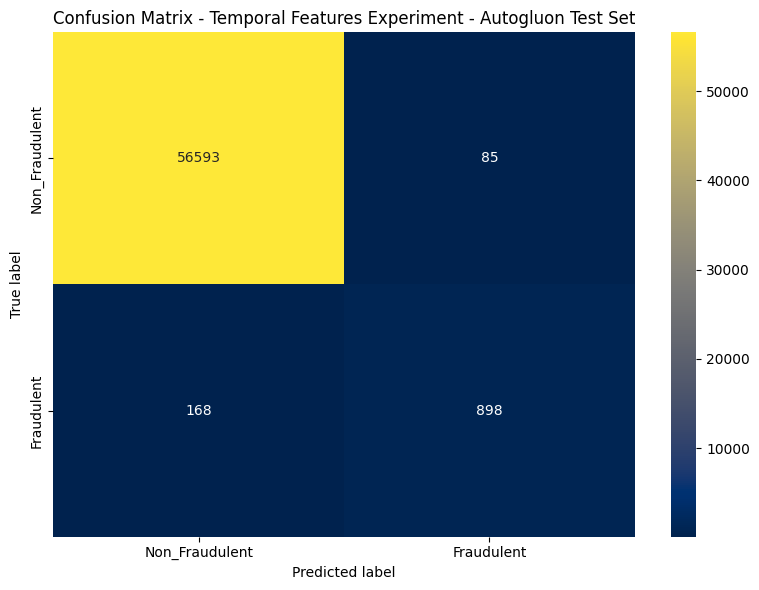

CPU times: user 27.8 s, sys: 153 ms, total: 28 s
Wall time: 2.96 s


In [22]:
%%time

target_column = "fraud"
feature_columns = [column for column in train_df.columns if column != target_column]

X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].astype(int).copy()

metrics = evaluate_model(
    model=predictor,
    X=X_test,
    y=y_test,
    name="Temporal Features Experiment - Autogluon Test Set"
)

### 4- Saving predictor

In [23]:
%%time

predictor.save()

CPU times: user 167 ms, sys: 11 μs, total: 167 ms
Wall time: 166 ms


### 5- Feature importances on validation set

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_df = pd.read_csv("data/validation_temporal_features.csv")
save_path = "models/temporal-features-autogluon-tabular-predictor"
predictor = TabularPredictor.load(save_path, verbosity=2)

In [3]:
# Permutation importance
feature_importances = predictor.feature_importance(
    data=val_df,
    subsample_size=None, # set None to use all rows
    num_shuffle_sets=5 # tighter confidence bands (more compute)
).sort_values("importance", ascending=False)

These features in provided data are not utilized by the predictor and will be ignored: ['gender_E']
Computing feature importance via permutation shuffling for 53 features using 60291 rows with 5 shuffle sets...
/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
	1457.9s	= Expected runtime (291.58s per shuffle set)
	704.56s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [4]:
feature_importances

,importance,stddev,p_value,n,p99_high,p99_low
amount,0.592597,0.012183,2.142505e-08,5,0.617682,0.567512
category_es_transportation,0.246929,0.003548,5.113478e-09,5,0.254234,0.239624
cust_day_total_transactions,0.155187,0.006625,3.975148e-07,5,0.168828,0.141547
cust_day_total_amount,0.110018,0.003083,7.388565e-08,5,0.116365,0.103670
amount_divided_by_cust_day_mean_last_7_days,0.043504,0.003175,3.381831e-06,5,0.050043,0.036966
cust_amount_mean_prior_to_row,0.036685,0.003526,1.011791e-05,5,0.043945,0.029424
category_es_health,0.032909,0.001550,5.883149e-07,5,0.036100,0.029718
cust_day_amount_mean_last_7_days,0.030226,0.005099,9.360675e-05,5,0.040724,0.019727
step,0.026926,0.002343,6.813747e-06,5,0.031751,0.022101
amount_divided_by_cust_day_mean_last_30_days,0.025032,0.004165,8.866401e-05,5,0.033607,0.016456
